In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
FILE_PATH = "Physical_Activity_Monitoring_unlabeled.csv"

df = pd.read_csv(FILE_PATH)

# Optional: sort by time if not already
if "timestamp" in df.columns:
    df = df.sort_values("timestamp").reset_index(drop=True)

print("Rows, Cols:", df.shape)
print("Head:\n", df.head(2))

Rows, Cols: (534601, 53)
Head:
    timestamp  handTemperature  handAcc16_1  handAcc16_2  handAcc16_3  \
0      37.66           30.375      2.21530      8.27915      5.58753   
1      37.70           30.375      2.30106      7.25857      6.09259   

   handAcc6_1  handAcc6_2  handAcc6_3  handGyro1  handGyro2  ...  ankleGyro2  \
0     2.24689     8.55387     5.77143  -0.004750   0.037579  ...   -0.027714   
1     2.20720     7.24042     5.95555  -0.069961  -0.018328  ...   -0.048878   

   ankleGyro3  ankleMagne1  ankleMagne2  ankleMagne3  ankleOrientation1  \
0    0.001752     -61.1081     -36.8636     -58.3696                1.0   
1   -0.006328     -60.2040     -37.1225     -57.8847                1.0   

   ankleOrientation2  ankleOrientation3  ankleOrientation4  subject_id  
0                0.0                0.0                0.0           1  
1                0.0                0.0                0.0           1  

[2 rows x 53 columns]


In [ ]:
non_feature_candidates = ["timestamp", "subject_id", "label", "activity", "ActivityID", "Activity"]
non_feature_cols = [c for c in non_feature_candidates if c in df.columns]

# Keep only numeric columns
num_df = df.select_dtypes(include=[np.number]).copy()

# Drop non-feature numeric columns (if present)
X = num_df.drop(columns=non_feature_cols, errors="ignore")

In [ ]:
X.isna().sum()

,0
handTemperature,4041
handAcc16_1,4041
handAcc16_2,4041
handAcc16_3,4041
handAcc6_1,4041
handAcc6_2,4041
handAcc6_3,4041
handGyro1,4041
handGyro2,4041
handGyro3,4041


In [ ]:
# Handle NaNs
X = X.interpolate(method="linear", limit_direction="both")

In [ ]:
WINDOW_SIZE = 128   # number of rows per window (e.g., ~1–3s depending on sampling rate)
STEP_SIZE   = 64    # hop length (overlap = WINDOW_SIZE - STEP_SIZE)

def sliding_windows(dataframe, window_size, step_size):
    starts = range(0, len(dataframe) - window_size + 1, step_size)
    for s in starts:
        e = s + window_size
        yield s, e, dataframe.iloc[s:e]

windows = list(sliding_windows(X, WINDOW_SIZE, STEP_SIZE))
print("Total windows:", len(windows))

Total windows: 8352


In [ ]:
def extract_features(window_df):
    # All numeric, so we can compute vectorized stats
    arr = window_df.to_numpy(dtype=float)  # shape: (window_size, n_features)

    # Basic stats along axis=0 (per original feature)
    mean  = np.nanmean(arr, axis=0)
    std   = np.nanstd(arr, axis=0, ddof=1)
    min_  = np.nanmin(arr, axis=0)
    max_  = np.nanmax(arr, axis=0)
    med   = np.nanmedian(arr, axis=0)
    rms   = np.sqrt(np.nanmean(arr**2, axis=0))
    iqr   = np.nanpercentile(arr, 75, axis=0) - np.nanpercentile(arr, 25, axis=0)
    energy= np.nanmean(arr**2, axis=0)  # mean-squared (per feature)

    # Flatten into one row with column names
    feature_row = {}
    cols = window_df.columns.tolist()

    for i, c in enumerate(cols):
        feature_row[f"{c}__mean"]   = mean[i]
        feature_row[f"{c}__std"]    = std[i]
        feature_row[f"{c}__min"]    = min_[i]
        feature_row[f"{c}__max"]    = max_[i]
        feature_row[f"{c}__median"] = med[i]
        feature_row[f"{c}__rms"]    = rms[i]
        feature_row[f"{c}__iqr"]    = iqr[i]
        feature_row[f"{c}__energy"] = energy[i]

    return feature_row

In [ ]:
feature_rows = []
meta_rows = []  # keep a bit of context (start/end/time/subject) if available

for start_idx, end_idx, wdf in windows:
    feature_rows.append(extract_features(wdf))

    meta = {"start_idx": start_idx, "end_idx": end_idx}
    if "timestamp" in df.columns:
        meta["start_time"] = df.loc[start_idx, "timestamp"]
        meta["end_time"]   = df.loc[end_idx - 1, "timestamp"]
    if "subject_id" in df.columns:
        meta["subject_id"] = df.loc[start_idx:end_idx-1, "subject_id"].mode().iloc[0]
    meta_rows.append(meta)

features_df = pd.DataFrame(feature_rows)
meta_df = pd.DataFrame(meta_rows)

print("Features shape:", features_df.shape)

Features shape: (8352, 408)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

In [ ]:
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance (2D):", pca.explained_variance_ratio_.sum())

PCA explained variance (2D): 0.7423908695372443


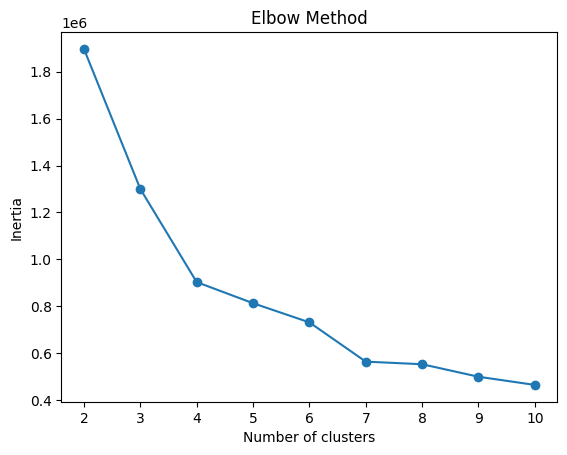

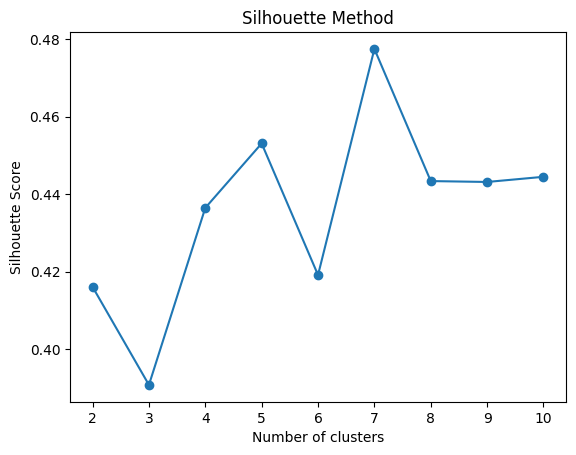

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
sil_scores = []
K_range = range(2, 11)  # test cluster counts from 2 to 10

for k in K_range:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X_pca)  # use PCA-reduced features
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca, labels))

# Plot inertia (elbow)
plt.plot(K_range, inertias, 'o-')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Plot silhouette score
plt.plot(K_range, sil_scores, 'o-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.show()

In [ ]:
N_CLUSTERS = 7
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init="auto", random_state=42)
labels = kmeans.fit_predict(X_scaled)

In [ ]:
if len(np.unique(labels)) > 1:
    sil = silhouette_score(X_scaled, labels)
    print("Silhouette score:", round(sil, 4))
else:
    print("Silhouette score skipped (only one cluster found).")

Silhouette score: 0.2523


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# ----------------------
# 1. Load & clean dataset
# ----------------------
df = pd.read_csv("Physical_Activity_Monitoring_unlabeled.csv")

# Drop identifiers (if they exist in your dataset)
df = df.drop(columns=["timestamp", "subject_id"], errors="ignore")

# Handle missing values
df = df.interpolate().dropna()

print("Data shape after cleaning:", df.shape)

# ----------------------
# 2. Normalize features
# ----------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# ----------------------
# 3. Dimensionality Reduction
# ----------------------
pca = PCA(n_components=20, random_state=42)   # try 20 PCs instead of 2 or 10
X_pca = pca.fit_transform(X_scaled)

print("Explained variance (20 PCs):", np.sum(pca.explained_variance_ratio_))

Data shape after cleaning: (534601, 51)
Explained variance (20 PCs): 0.8362033104559097


In [ ]:
kmeans = KMeans(n_clusters=7, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels, sample_size=1000, random_state=42)
print("KMeans Silhouette (k=7):", round(kmeans_silhouette, 4))

KMeans Silhouette (k=7): 0.1665


In [ ]:
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_pca)
gmm_silhouette = silhouette_score(X_pca, gmm_labels, sample_size=1000, random_state=42)
print("GMM Silhouette (k=7):", round(gmm_silhouette, 4))

GMM Silhouette (k=7): 0.0857


In [ ]:
!pip install hdbscan

import hdbscan
from sklearn.metrics import silhouette_score

clusterer = hdbscan.HDBSCAN(min_cluster_size=50)  # tune this
labels_hdb = clusterer.fit_predict(X_pca)

# Only compute silhouette if >1 cluster
if len(set(labels_hdb)) > 1:
    sil_hdb = silhouette_score(X_pca, labels_hdb)
    print(f"HDBSCAN Silhouette: {sil_hdb:.4f}")
else:
    print("HDBSCAN found only one cluster.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# ----------------------
# 5. Print Results
# ----------------------
print("\nSilhouette Scores:")
for method, score in results.items():
    print(f"{method}: {score:.4f}")

In [1]:
import re
import math
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from scipy.fft import rfft, rfftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
import umap
import matplotlib.pyplot as plt

# ---------------------------
# 1) Load data
# ---------------------------
df = pd.read_csv("Physical_Activity_Monitoring_unlabeled.csv")   # change path if needed
# ensure timestamp numeric
df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')

In [2]:
def preprocess(df):
    # Sort and reset
    df = df.sort_values(['subject_id','timestamp']).reset_index(drop=True)
    # Identify numeric columns (exclude subject_id and timestamp and optional activity)
    exclude = ['subject_id','timestamp']
    if 'activity' in df.columns:
        exclude.append('activity')
    numeric_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
    # Fill / interpolate per subject
    out = []
    for sid, g in df.groupby('subject_id'):
        g = g.copy()
        # simple linear interpolation
        g[numeric_cols] = g[numeric_cols].interpolate(method='linear', limit_direction='both', axis=0)
        # if still NaN (start/end), fill with median
        g[numeric_cols] = g[numeric_cols].fillna(g[numeric_cols].median())
        out.append(g)
    df2 = pd.concat(out, ignore_index=True)
    return df2

df = preprocess(df)

In [3]:
def estimate_fs(df):
    # returns dictionary subject_id -> fs (Hz)
    out = {}
    for sid, g in df.groupby('subject_id'):
        diffs = g['timestamp'].diff().dropna()
        if len(diffs)==0:
            out[sid] = np.nan
        else:
            median_dt = diffs.median()
            fs = 1.0/median_dt if median_dt > 0 else np.nan
            out[sid] = fs
    return out

In [4]:
fs_by_subject = estimate_fs(df)
print("Estimated sampling rates (Hz) per subject sample:", list(fs_by_subject.items())[:5])

Estimated sampling rates (Hz) per subject sample: [(1, 99.99999999781721), (2, 50.000000000045475), (3, 99.99999999781721), (4, 50.000000000045475), (5, 50.000000000045475)]


In [5]:
def sliding_windows(df, window_seconds=5.0, overlap=0.5):
    """
    Returns list of dicts: {subject, start_time, end_time, window_df}
    window_seconds: e.g., 5.0
    overlap: fraction (0..1) of overlap (0.5 => 50% overlap)
    """
    windows = []
    for sid, g in df.groupby('subject_id'):
        g = g.reset_index(drop=True)
        fs = fs_by_subject.get(sid, np.nan)
        if np.isnan(fs) or fs <= 0:
            continue
        win_samples = max(2, int(round(window_seconds * fs)))
        step = max(1, int(round(win_samples * (1 - overlap))))
        n = len(g)
        for start in range(0, n - win_samples + 1, step):
            w = g.iloc[start:start+win_samples].copy()
            windows.append({'subject': sid,
                            'start_time': float(w['timestamp'].iloc[0]),
                            'end_time': float(w['timestamp'].iloc[-1]),
                            'df': w})
    return windows

windows = sliding_windows(df, window_seconds=5.0, overlap=0.5)
print("Number of windows:", len(windows))

Number of windows: 2963


In [6]:
def signal_entropy(x, bins=10):
    h, _ = np.histogram(x, bins=bins, density=True)
    # avoid zeros
    p = h + 1e-12
    p = p / p.sum()
    return entropy(p)

def fft_features(x, fs):
    n = len(x)
    if n < 2:
        return {'fft_peak_freq': 0.0, 'fft_spectral_energy': 0.0}
    # remove mean (DC)
    x = x - np.mean(x)
    X = np.abs(rfft(x))
    freqs = rfftfreq(n, d=1.0/fs)
    # spectral energy (sum of squared magnitudes normalized)
    spec_energy = np.sum(X**2) / n
    # ignore DC bin (index 0) for peak
    if len(X) > 1:
        idx = np.argmax(X[1:]) + 1
        peak_freq = float(freqs[idx])
    else:
        peak_freq = 0.0
    return {'fft_peak_freq': peak_freq, 'fft_spectral_energy': float(spec_energy)}

In [7]:
def extract_features_from_window(win_dict):
    wdf = win_dict['df']
    sid = win_dict['subject']
    fs = fs_by_subject[sid]
    # list all sensor columns except timestamp/subject/activity
    exclude = ['timestamp','subject_id']
    if 'activity' in wdf.columns:
        exclude.append('activity')
    cols = [c for c in wdf.columns if c not in exclude]
    feats = {}
    # global aggregated channels: magnitude for acc6 (3-axis) for each sensor (hand/chest/ankle)
    sensors = ['hand','chest','ankle']
    for s in sensors:
        # columns that start with s
        scols = [c for c in cols if c.startswith(s)]
        # group by feature prefix after sensor name
        feature_buckets = {}
        for c in scols:
            rest = c[len(s):]   # e.g. "Acc6_1" or "Orientation1" or "Temperature"
            # split alpha prefix from rest
            m = re.match(r'([A-Za-z]+)', rest)
            if m:
                key = m.group(1)
            else:
                key = rest
            feature_buckets.setdefault(key, []).append(c)
        # iterate buckets
        for key, bucket in feature_buckets.items():
            # if it's a multi-axis channel (3 columns)
            if len(bucket) >= 3:
                # compute axis-wise features and magnitude features
                arr = wdf[bucket].values
                # magnitude (L2) along axis
                mag = np.linalg.norm(arr[:, :3].astype(float), axis=1)  # first 3 used if more exist
                # time-domain features for magnitude
                feats[f'{s}_{key}_mag_mean'] = float(np.mean(mag))
                feats[f'{s}_{key}_mag_std']  = float(np.std(mag))
                feats[f'{s}_{key}_mag_skew'] = float(skew(mag))
                feats[f'{s}_{key}_mag_kurt'] = float(kurtosis(mag))
                feats[f'{s}_{key}_mag_energy']= float(np.sum(mag**2)/len(mag))
                feats[f'{s}_{key}_mag_entropy']= float(signal_entropy(mag))
                # freq features on magnitude
                ff = fft_features(mag, fs)
                feats[f'{s}_{key}_mag_fft_peak_freq'] = ff['fft_peak_freq']
                feats[f'{s}_{key}_mag_spectral_energy'] = ff['fft_spectral_energy']
                # also compute per-axis means (helps discriminate orientation/axis-dominant movement)
                for i, col in enumerate(bucket[:3]):
                    colvals = wdf[col].astype(float).values
                    feats[f'{s}_{key}_axis{i+1}_mean'] = float(np.mean(colvals))
                    feats[f'{s}_{key}_axis{i+1}_std']  = float(np.std(colvals))
            else:
                # single-column feature: temperature, orientation components, etc.
                col = bucket[0]
                arr = wdf[col].astype(float).values
                feats[f'{s}_{key}_mean'] = float(np.mean(arr))
                feats[f'{s}_{key}_std']  = float(np.std(arr))
                feats[f'{s}_{key}_skew'] = float(skew(arr))
                feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
                feats[f'{s}_{key}_entropy'] = float(signal_entropy(arr))
                ff = fft_features(arr, fs)
                feats[f'{s}_{key}_fft_peak_freq'] = ff['fft_peak_freq']
                feats[f'{s}_{key}_spectral_energy'] = ff['fft_spectral_energy']
    # add meta
    feats['subject_id'] = sid
    feats['start_time'] = win_dict['start_time']
    feats['end_time'] = win_dict['end_time']
    # if ground-truth activity column exists, take mode of activity in window
    if 'activity' in wdf.columns:
        feats['activity'] = wdf['activity'].mode().iloc[0]
    return feats

In [8]:
feature_rows = []
for i, w in enumerate(windows):
    feature_rows.append(extract_features_from_window(w))
    if (i+1) % 200 == 0:
        print(f"Extracted features for {i+1} windows...")

features_df = pd.DataFrame(feature_rows).fillna(0.0)
print("Feature matrix shape:", features_df.shape)

/tmp/ipython-input-833532466.py:38: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_mag_skew'] = float(skew(mag))
/tmp/ipython-input-833532466.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_mag_kurt'] = float(kurtosis(mag))
/tmp/ipython-input-833532466.py:38: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_mag_skew'] = float(skew(mag))
/tmp/ipython-input-833532466.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key

Extracted features for 200 windows...


/tmp/ipython-input-833532466.py:38: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_mag_skew'] = float(skew(mag))
/tmp/ipython-input-833532466.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_mag_kurt'] = float(kurtosis(mag))
/tmp/ipython-input-833532466.py:38: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_mag_skew'] = float(skew(mag))
/tmp/ipython-input-833532466.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key

Extracted features for 400 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 600 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 800 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 1000 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 1200 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 1400 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 1600 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 1800 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 2000 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 2200 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 2400 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 2600 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Extracted features for 2800 windows...


/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = float(kurtosis(arr))
/tmp/ipython-input-833532466.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_skew'] = float(skew(arr))
/tmp/ipython-input-833532466.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  feats[f'{s}_{key}_kurt'] = f

Feature matrix shape: (2963, 192)


In [9]:
meta_cols = ['subject_id','start_time','end_time','activity'] if 'activity' in features_df.columns else ['subject_id','start_time','end_time']
X = features_df.drop(columns=meta_cols, errors='ignore').values
# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
reducer = umap.UMAP(n_components=2, random_state=42, min_dist=0.5)
X_umap = reducer.fit_transform(X_scaled)
print("UMAP done, shape:", X_umap.shape)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done, shape: (2963, 2)


In [11]:
def eval_and_print(labels, X_embedded, method_name="cluster"):
    # if single cluster or only noise, silhouette score will error; handle gracefully
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    out = {'n_clusters': n_clusters}
    if n_clusters >= 2:
        out['silhouette'] = silhouette_score(X_embedded, labels)
        out['db_index'] = davies_bouldin_score(X_embedded, labels)
    else:
        out['silhouette'] = None
        out['db_index'] = None
    print(f"{method_name}: clusters={n_clusters}, silhouette={out['silhouette']}, db={out['db_index']}")
    return out

In [12]:
k_candidates = [5,6]
kmeans_results = {}
for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_umap)
    labels = km.labels_
    kmeans_results[k] = {'labels': labels, **eval_and_print(labels, X_umap, f'KMeans(k={k})')}

KMeans(k=5): clusters=5, silhouette=0.500251293182373, db=0.7413219369211363
KMeans(k=6): clusters=6, silhouette=0.530605673789978, db=0.6924225269829348


In [13]:
agg_results = {}
for k in [3,5]:
    agg = AgglomerativeClustering(n_clusters=k).fit(X_umap)
    labels = agg.labels_
    agg_results[k] = {'labels': labels, **eval_and_print(labels, X_umap, f'Agglomerative(k={k})')}

Agglomerative(k=3): clusters=3, silhouette=0.4597928524017334, db=0.8653432258574371
Agglomerative(k=5): clusters=5, silhouette=0.5003811717033386, db=0.7448615545588663


In [14]:
if 'activity' in features_df.columns:
    gt = features_df['activity'].values
    print("Ground truth present; computing ARI/NMI vs KMeans best (by silhouette)...")
    # choose best k by silhouette
    best_k = max(kmeans_results.items(), key=lambda kv: (kv[1]['silhouette'] or -1))[0]
    best_labels = kmeans_results[best_k]['labels']
    print("Best K by silhouette:", best_k)
    print("ARI:", adjusted_rand_score(gt, best_labels))
    print("NMI:", normalized_mutual_info_score(gt, best_labels))

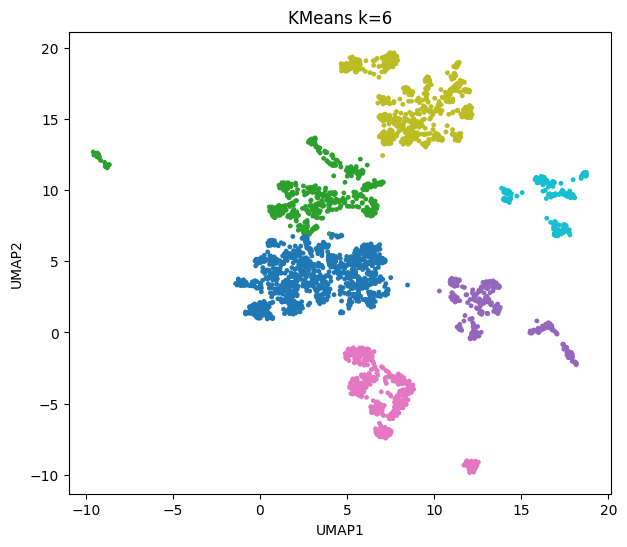

In [15]:
def plot_embedding(X_emb, labels, title="embedding", show=True, figsize=(7,6)):
    plt.figure(figsize=figsize)
    # try to map -1 to a color (noise)
    plt.scatter(X_emb[:,0], X_emb[:,1], c=labels, cmap='tab10', s=6)
    plt.title(title)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    if show:
        plt.show()

# Plot a few results
# KMeans with best_k
best_k = max(kmeans_results.items(), key=lambda kv: (kv[1]['silhouette'] or -1))[0]
plot_embedding(X_umap, kmeans_results[best_k]['labels'], f"KMeans k={best_k}")

In [16]:
if 'activity' in features_df.columns:
    # map string labels to ints for plotting
    unique_labels = pd.Categorical(features_df['activity']).codes
    plot_embedding(X_umap, unique_labels, "Ground truth activities")

# ---------------------------
# 12) Save cluster labels back to features_df
# ---------------------------
# choose to store the best clustering labels (e.g., best_k)
features_df['kmeans_best'] = kmeans_results[best_k]['labels']

# optionally save
features_df.to_csv("window_features_with_clusters.csv", index=False)
print("Saved features+clusters to window_features_with_clusters.csv")

Saved features+clusters to window_features_with_clusters.csv
